# Now it's your turn!

Use the following dataset of scraped "Data Scientist" and "Data Analyst" job listings to create your own Document Classification Models.

<https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-2-NLP/master/module3-Document-Classification/job_listings.csv>

Requirements:

- Apply both CountVectorizer and TfidfVectorizer methods to this data and compare results
- Use at least two different classification models to compare differences in model accuracy
- Try to "Hyperparameter Tune" your model by using different n_gram ranges, max_results, and data cleaning methods
- Try and get the highest accuracy possible!

## Cleaning the data

In [2]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)

In [3]:
df = pd.read_csv('job_listings.csv', header=0)
df.head()

,description,title,job
0,"b""<div><div>Job Requirements:</div><ul><li><p>\nConceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random For...",Data scientist,Data Scientist
1,"b'<div>Job Description<br/>\n<br/>\n<p>As a Data Scientist 1, you will help us build machine learning models, data pipelines, and micro-services to help our clients navigate their healthcare journ...",Data Scientist I,Data Scientist
2,"b'<div><p>As a Data Scientist you will be working on consulting side of our business. You will be responsible for analyzing large, complex datasets and identify meaningful patterns that lead to ac...",Data Scientist - Entry Level,Data Scientist
3,"b'<div class=""jobsearch-JobMetadataHeader icl-u-xs-mb--md""><div class=""jobsearch-JobMetadataHeader-item ""><span class=""icl-u-xs-mr--xs"">$4,969 - $6,756 a month</span></div><div class=""jobsearch-Jo...",Data Scientist,Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple locations</li>\n<li>2+ years of Analytics experience</li>\n<li>Understand business requirements and technical requirements</li>\n<li>Can handle data e...,Data Scientist,Data Scientist


In [4]:
df.isnull().sum()

description    1
title          1
job            0
dtype: int64

In [5]:
df.shape

(500, 3)

### Since we have 500 rows, we will remove the one with NULL values in it. It won't matter to the prediction

In [6]:
df2 = df.dropna(axis=0, how='any').copy()
df2.shape

(499, 3)

In [7]:
from bs4 import BeautifulSoup

def clean_html(x):
    soup = BeautifulSoup(x[2:-1])
    return soup.get_text()

df2.description = df2.description.apply(clean_html)
df2.head()

,description,title,job
0,"Job Requirements:\nConceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN al...",Data scientist,Data Scientist
1,"Job Description\n\nAs a Data Scientist 1, you will help us build machine learning models, data pipelines, and micro-services to help our clients navigate their healthcare journey. You will do so b...",Data Scientist I,Data Scientist
2,"As a Data Scientist you will be working on consulting side of our business. You will be responsible for analyzing large, complex datasets and identify meaningful patterns that lead to actionable r...",Data Scientist - Entry Level,Data Scientist
3,"$4,969 - $6,756 a monthContractUnder the general supervision of Professors Dana Mukamel and Kai Zheng, the incumbent will join the CalMHSA Mental Health Tech Suite Innovation (INN) Evaluation Team...",Data Scientist,Data Scientist
4,"Location: USA \xe2\x80\x93 multiple locations\n2+ years of Analytics experience\nUnderstand business requirements and technical requirements\nCan handle data extraction, preparation and transforma...",Data Scientist,Data Scientist


### Decoding unicode characters

In [8]:
from unidecode import unidecode

def decode_unicode_string(x):
    return unidecode(x)

df2.description = df2.description.apply(decode_unicode_string)
df2.description.values

# Still a problem, though.
# string = u'Nai\\xc2\\xa8ve Bayes'
# unidecode(string)

array(["Job Requirements:\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\\nHands on experience in SQL/Hive or similar programming language\\nMust show past work via GitHub, Kaggle or any other published article\\nMaster's degree in Statistics/Mathematics/Computer Science or any other quant specific field.\\nApply Now",
       'Job Description\\n\\nAs a Data Scientist 1, you will help us build machine learning models, data pipelines, and micro-services to help ou

### Categorical encoding on labels

In [9]:
df2.job = df2.job.str.lower()
df2.job = df2.job.map({'data analyst': 0, 'data scientist': 1})
df2.job.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
df2.title.value_counts()

Data Scientist                                                     84
Data Analyst                                                       80
Data Analyst Intern                                                13
Senior Data Scientist                                               8
Senior Data Analyst                                                 8
Junior Data Analyst                                                 7
Data Scientist Intern                                               7
Junior Data Scientist                                               6
Associate Data Scientist                                            6
Sr. Data Scientist                                                  5
Data Scientist, Product                                             4
Data Scientist II                                                   4
Jr. Data Scientist                                                  3
DATA SCIENTIST                                                      3
Data Analyst I      

### We don't need this column, so drop it

In [11]:
df2 = df2.drop(['title'], axis=1)
df2.head()

,description,job
0,"Job Requirements:\nConceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN al...",1
1,"Job Description\n\nAs a Data Scientist 1, you will help us build machine learning models, data pipelines, and micro-services to help our clients navigate their healthcare journey. You will do so b...",1
2,"As a Data Scientist you will be working on consulting side of our business. You will be responsible for analyzing large, complex datasets and identify meaningful patterns that lead to actionable r...",1
3,"$4,969 - $6,756 a monthContractUnder the general supervision of Professors Dana Mukamel and Kai Zheng, the incumbent will join the CalMHSA Mental Health Tech Suite Innovation (INN) Evaluation Team...",1
4,"Location: USA \xe2\x80\x93 multiple locations\n2+ years of Analytics experience\nUnderstand business requirements and technical requirements\nCan handle data extraction, preparation and transforma...",1


In [12]:
df2.job.value_counts()

1    250
0    249
Name: job, dtype: int64

In [13]:
from nltk.tokenize import word_tokenize

def words_to_string(words_per_listing):
    res = []
    for words in words_per_listing:
        res.append(' '.join(words))
    return res

def remove_stopwords(l):
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')    # NLTK has a list of stopwords you can use.
    
    return [w for w in l if w not in stop_words]

listings = df2.description.values
words_per_listing = []
for l in listings:
    lowercase = l.lower()                # Lowercase before removing stopwords.
    tokens = word_tokenize(lowercase)

    words = [w for w in tokens if w.isalpha()] # Keep only words with alphabet characters.
                                               # isalpha() is True if all characters
                                               # are alphabetic.
    
    words = remove_stopwords(words)
    words_per_listing.append(words)

strings_per_listing = words_to_string(words_per_listing)
strings_per_listing

['job requirements understanding machine learning models like bayes svm apriori logistic regression neural random forests decision trees along experience least expert level coding skills ability write functions clean efficient data manipulation mandatory role packages like numpy scipy pandas matplotlib etc python dplyr tidyr communicate model findings technical stake experience similar programming show past work via github kaggle published degree science quant specific',
 'job data scientist help us build machine learning models data pipelines help clients navigate healthcare journey empowering improving next generation accolade applications user day small agile team design develop mobile applications iterative group development team members best practices help guide future effectively collaborative member development effectively individual quick turnaround enhancements meeting expectations deliverables time high implement new features within mobile thorough manual testing writing test

### Applying various models to the data

In [14]:
from sklearn.model_selection import train_test_split

def split_data(df):
    X = df.description
    y = df.job
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df2)

(399,) (399,)
(100,) (100,)


In [15]:
from sklearn.feature_extraction.text import CountVectorizer, \
                                            TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

def test_model(pipeline_list, scoring_function, X_train, X_test, y_train, y_test):
    pipeline = Pipeline(pipeline_list)
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # It's best to use pipeline.classes_ to find the class to
                                                        # index mapping on the second index of the return value from
                                                        # the predict_proba function.
    print('score:', scoring_function(y_test, y_pred_proba))
    # print('vocabulary:', p.named_steps[pipeline_list[0][0]].vocabulary_)
    return pipeline

p = test_model([('CountVectorizer', CountVectorizer(max_features=None, ngram_range=(1, 1), stop_words='english')),
                ('LogisticRegression', LogisticRegression(solver='lbfgs', max_iter=200, random_state=1))],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.9882828282828283


In [16]:
for m_features in range(20, 400, 20):
    test_model([('CountVectorizer', CountVectorizer(max_features=m_features, ngram_range=(1, 1), stop_words='english')),
                ('LogisticRegression', LogisticRegression(solver='lbfgs', max_iter=200, random_state=1))],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.8775757575757576
score: 0.8985858585858586
score: 0.9575757575757575
score: 0.9587878787878787
score: 0.9741414141414141
score: 0.9745454545454546
score: 0.9822222222222222
score: 0.9753535353535354
score: 0.9797979797979799
score: 0.9842424242424241
score: 0.9886868686868687
score: 0.9903030303030302
score: 0.9927272727272727
score: 0.9915151515151516
score: 0.9903030303030304
score: 0.9927272727272728
score: 0.9919191919191919
score: 0.9907070707070708
score: 0.9907070707070708


### The test score is very very high - and it gets there quickly using just 60-100 features. Here we have used the fully-cleaned string (HTML cleaned out, stopwords removed, all words containing something other than alphabets removed).

### Let's use the original description values (with just the HTML cleaned out of it.

In [17]:
df_original = df.copy().drop(['title'], axis=1)
df_original = df_original.dropna(axis=0, how='any')

def clean_html(x):
    soup = BeautifulSoup(x[2:-1])
    return soup.get_text()

df_original.description = df_original.description.apply(clean_html)
df_original.head()

,description,job
0,"Job Requirements:\nConceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN al...",Data Scientist
1,"Job Description\n\nAs a Data Scientist 1, you will help us build machine learning models, data pipelines, and micro-services to help our clients navigate their healthcare journey. You will do so b...",Data Scientist
2,"As a Data Scientist you will be working on consulting side of our business. You will be responsible for analyzing large, complex datasets and identify meaningful patterns that lead to actionable r...",Data Scientist
3,"$4,969 - $6,756 a monthContractUnder the general supervision of Professors Dana Mukamel and Kai Zheng, the incumbent will join the CalMHSA Mental Health Tech Suite Innovation (INN) Evaluation Team...",Data Scientist
4,"Location: USA \xe2\x80\x93 multiple locations\n2+ years of Analytics experience\nUnderstand business requirements and technical requirements\nCan handle data extraction, preparation and transforma...",Data Scientist


In [18]:
X_train, X_test, y_train, y_test = split_data(df_original)

(399,) (399,)
(100,) (100,)


In [19]:
for m_features in range(20, 400, 20):
    test_model([('CountVectorizer', CountVectorizer(max_features=m_features, ngram_range=(1, 1), stop_words='english')),
                ('LogisticRegression', LogisticRegression(solver='lbfgs', max_iter=200, random_state=1))],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.8775757575757576
score: 0.8985858585858586
score: 0.9575757575757575
score: 0.9587878787878787
score: 0.9741414141414141
score: 0.9745454545454546
score: 0.9822222222222222
score: 0.9753535353535354
score: 0.9797979797979799
score: 0.9842424242424241
score: 0.9886868686868687
score: 0.9903030303030302
score: 0.9927272727272727
score: 0.9915151515151516
score: 0.9903030303030304
score: 0.9927272727272728
score: 0.9919191919191919
score: 0.9907070707070708
score: 0.9907070707070708


In [20]:
for m_features in range(20, 400, 20):
    test_model([('TfidfVectorizer', TfidfVectorizer(max_features=m_features, 
                                                    ngram_range=(1, 1), 
                                                    stop_words='english')),
                ('LogisticRegression', LogisticRegression(solver='lbfgs', max_iter=200, random_state=1))],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.8913131313131313
score: 0.934949494949495
score: 0.9632323232323232
score: 0.9567676767676768
score: 0.9575757575757575
score: 0.9543434343434344
score: 0.9579797979797979
score: 0.9583838383838383
score: 0.9624242424242424
score: 0.9640404040404041
score: 0.9648484848484848
score: 0.9680808080808081
score: 0.9713131313131314
score: 0.9737373737373737
score: 0.9725252525252525
score: 0.9713131313131312
score: 0.9668686868686869
score: 0.9636363636363637
score: 0.9616161616161617


### Here again, the test score gets high very fast - within 60-100 features. It looks like the CountVectorizer is doing a good job of cleaning the data before passing it to  LogisticRegression.
### The TfidfVectorizer is not as good as the CountVectorizer.
### From now on, we will only use the original data

In [21]:
m_features = 60
for ngram_max in range(1, 4):
    test_model([('CountVectorizer', CountVectorizer(max_features=m_features, ngram_range=(1, ngram_max), stop_words='english')),
                ('LogisticRegression', LogisticRegression(solver='lbfgs', max_iter=200, random_state=1))],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.9575757575757575
score: 0.962020202020202
score: 0.9571717171717171


In [22]:
m_features = 60
for ngram_max in range(1, 4):
    test_model([('TfidfVectorizer', TfidfVectorizer(max_features=m_features, 
                                                    ngram_range=(1, ngram_max), 
                                                    stop_words='english')),
                ('LogisticRegression', LogisticRegression(solver='lbfgs', max_iter=200, random_state=1))],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.9632323232323232
score: 0.9600000000000001
score: 0.9571717171717172


### Looks like bigrams do slightly better than trigrams. Maybe this is because there aren't many real trigrams within the top 60 features we have selected to use.
### Let's try Multinomial Naive Bayes

In [23]:
from sklearn.naive_bayes import MultinomialNB

m_features = 60
for ngram_max in range(1, 4):
    test_model([('CountVectorizer', CountVectorizer(max_features=m_features, 
                                                    ngram_range=(1, ngram_max), 
                                                    stop_words='english')),
                ('MultinomialNB', MultinomialNB())],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.964040404040404
score: 0.9591919191919193
score: 0.9583838383838384


In [24]:
from sklearn.naive_bayes import MultinomialNB

m_features = 60
for ngram_max in range(1, 4):
    test_model([('TfidfVectorizer', TfidfVectorizer(max_features=m_features, 
                                                    ngram_range=(1, ngram_max), 
                                                    stop_words='english')),
                ('MultinomialNB', MultinomialNB())],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.955959595959596
score: 0.9535353535353536
score: 0.9535353535353535


In [25]:
for m_features in range(20, 400, 20):
    test_model([('CountVectorizer', CountVectorizer(max_features=m_features, 
                                                    ngram_range=(1, 1), 
                                                    stop_words='english')),
                ('MultinomialNB', MultinomialNB())],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.8888888888888888
score: 0.9143434343434343
score: 0.964040404040404
score: 0.9503030303030303
score: 0.9519191919191918
score: 0.9458585858585858
score: 0.9511111111111111
score: 0.9519191919191919
score: 0.9531313131313132
score: 0.9571717171717172
score: 0.9555555555555555
score: 0.9571717171717171
score: 0.9604040404040404
score: 0.964040404040404
score: 0.9624242424242424
score: 0.9583838383838384
score: 0.9507070707070707
score: 0.947878787878788
score: 0.9507070707070707


In [26]:
for m_features in range(20, 400, 20):
    test_model([('TfidfVectorizer', TfidfVectorizer(max_features=m_features, 
                                                    ngram_range=(1, 1), 
                                                    stop_words='english')),
                ('MultinomialNB', MultinomialNB())],
               roc_auc_score, X_train, X_test, y_train, y_test)

score: 0.8824242424242426
score: 0.9309090909090909
score: 0.955959595959596
score: 0.9482828282828283
score: 0.9490909090909091
score: 0.9434343434343435
score: 0.9454545454545454
score: 0.9482828282828283
score: 0.9498989898989899
score: 0.953939393939394
score: 0.9543434343434344
score: 0.9575757575757576
score: 0.96
score: 0.9608080808080809
score: 0.9563636363636364
score: 0.9503030303030303
score: 0.9470707070707071
score: 0.9494949494949494
score: 0.9470707070707072


### Multinomial Naive Bayes is almost as good, just 3 percent poor compared to LogisticRegression

# Stretch Goals

- Try some clustering using Ward

- Awesome resource for clustering stretch goals: 
 - Agglomerative Clustering with Scipy: <https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/>
 - Agglomerative Clustering for NLP: <http://brandonrose.org/clustering>
 
- Use Latent Dirichlet Allocation (LDA) to perform topic modeling on the dataset: 
 - Topic Modeling and LDA in Python: <https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24>
 - Topic Modeling and LDA using Gensim: <https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/>


### Hierarchical Clustering and Dendrogram
#### Let's use the data we have already cleaned above

In [27]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage

In [60]:
X = strings_per_listing
vectorizer = TfidfVectorizer(max_features=50, ngram_range=(1,2), stop_words='english')

train_word_counts = vectorizer.fit_transform(X)

print(vectorizer.vocabulary_)

{'machine': 22, 'learning': 21, 'models': 25, 'experience': 15, 'skills': 34, 'ability': 0, 'data': 9, 'technical': 43, 'work': 47, 'degree': 11, 'science': 33, 'machine learning': 23, 'help': 16, 'team': 42, 'develop': 12, 'development': 13, 'new': 26, 'product': 30, 'analytical': 3, 'business': 5, 'computer': 7, 'related': 31, 'working': 48, 'management': 24, 'customer': 8, 'company': 6, 'information': 18, 'support': 40, 'statistical': 37, 'position': 29, 'research': 32, 'engineering': 14, 'statistics': 38, 'people': 28, 'status': 39, 'years': 49, 'analytics': 4, 'tools': 45, 'analysis': 1, 'sql': 36, 'solutions': 35, 'insights': 19, 'opportunity': 27, 'using': 46, 'analyst': 2, 'systems': 41, 'technology': 44, 'data science': 10, 'including': 17, 'knowledge': 20}


In [61]:
X_train_vectorized = pd.DataFrame(train_word_counts.toarray(), columns=vectorizer.get_feature_names())

print(X_train_vectorized.shape)
X_train_vectorized.head()

(499, 50)


,ability,analysis,analyst,analytical,analytics,business,company,computer,customer,data,...,support,systems,team,technical,technology,tools,using,work,working,years
0,0.293599,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162113,...,0.000000,0.0,0.000000,0.305114,0.0,0.0,0.0,0.202499,0.000000,0.00000
1,0.095568,0.0,0.0,0.097784,0.000000,0.068709,0.103077,0.095809,0.115626,0.211074,...,0.000000,0.0,0.209610,0.297947,0.0,0.0,0.0,0.131828,0.177596,0.00000
2,0.000000,0.0,0.0,0.195526,0.000000,0.412164,0.000000,0.191578,0.000000,0.316543,...,0.187308,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.177558,0.00000
3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269198,...,0.000000,0.0,0.534663,0.000000,0.0,0.0,0.0,0.336260,0.000000,0.00000
4,0.000000,0.0,0.0,0.000000,0.386703,0.299930,0.000000,0.000000,0.000000,0.460694,...,0.000000,0.0,0.000000,0.433537,0.0,0.0,0.0,0.000000,0.000000,0.36067


#### I took the transpose here because the Dendrogram groups the rows. We want to group the words (which are columns now), so we transpose and convert it into an ndarray.

In [75]:
vectorized_word_counts = X_train_vectorized.T.values

In [76]:
Z = linkage(vectorized_word_counts, 'ward')

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_distances = cophenet(Z, pdist(vectorized_word_counts))
c

0.9047821266696816

#### The cophenet function compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances, which in our case is not close at all.

#### A cophenet distance of 0.9 seems like a good realistic correlation

In [77]:
Z[:20]

array([[22.        , 23.        ,  0.50748883,  2.        ],
       [10.        , 33.        ,  1.52351661,  2.        ],
       [21.        , 50.        ,  1.81447865,  3.        ],
       [ 7.        , 38.        ,  1.91914462,  2.        ],
       [11.        , 31.        ,  2.00800059,  2.        ],
       [53.        , 54.        ,  2.26180802,  4.        ],
       [36.        , 45.        ,  2.4089267 ,  2.        ],
       [27.        , 46.        ,  2.46491044,  2.        ],
       [ 3.        , 57.        ,  2.53768779,  3.        ],
       [43.        , 55.        ,  2.58941754,  5.        ],
       [12.        , 16.        ,  2.59715018,  2.        ],
       [56.        , 58.        ,  2.645718  ,  5.        ],
       [ 0.        , 20.        ,  2.66236489,  2.        ],
       [35.        , 44.        ,  2.68737454,  2.        ],
       [41.        , 59.        ,  2.71309758,  6.        ],
       [ 2.        , 17.        ,  2.73292985,  2.        ],
       [48.        , 62.

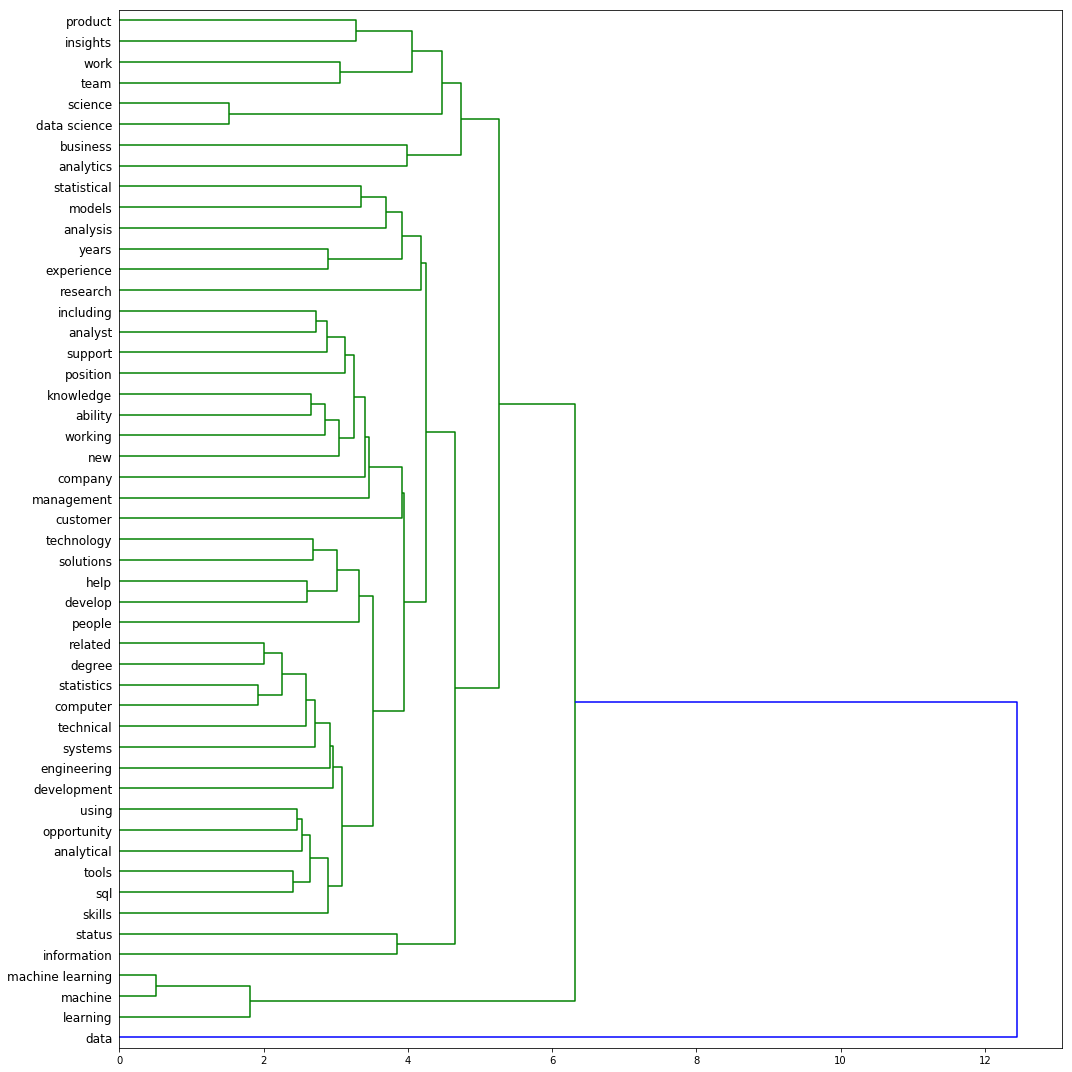

In [91]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = dendrogram(Z, 
                orientation='right', 
                leaf_font_size=12.,
                labels=vectorizer.get_feature_names())
plt.tight_layout()
# plt.savefig('dendrogram_of_job_listings.png', dpi=400)

In [92]:
plt.close()